In [2]:
"""Import statements as required"""
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
"""Multiple dataframes based on input files"""
filenames = ["results", "goalscorers", "shootouts"]
dataframes = {}
for filename in filenames:
    df = pd.read_csv(f"../Data/{filename}.csv")
    dataframes[filename] = df

print("Original match count", len(dataframes["results"]))

Original match count 47980


In [4]:
"""Join dataframes and add fields to round out overall stats"""
results = dataframes["results"].join(dataframes["shootouts"].set_index(["date", "home_team", "away_team"]), on=["date", "home_team", "away_team"])
results = results.join(dataframes["goalscorers"].set_index(["date", "home_team", "away_team"]), on=["date", "home_team", "away_team"])

# covert data type
results["neutral"] = results["neutral"].astype("int")
results["own_goal"] = (results["own_goal"] == True).astype("int")
results["penalty"] = (results["penalty"] == True).astype("int")
results["first_shooter"] = (results["first_shooter"] == results["home_team"]).astype("int")

# add new fields
results["draw"] = (results["home_score"] == results["away_score"]).astype("int")
results["home_victory"] = (results["home_score"] > results["away_score"]).astype("int")
results["shootout_required"] = (results["winner"].notnull()).astype("int")

# modify added fields to reflect data interaction
results.loc[results["home_team"] == results["winner"], "home_victory"] = 1
results.loc[results["winner"].notnull(), "draw"] = 0

# remove superfluous data
results = results.drop(columns=["date", "city", "country", "winner", "team", "scorer"])

results.head()

,home_team,away_team,home_score,away_score,tournament,neutral,first_shooter,minute,own_goal,penalty,draw,home_victory,shootout_required
0,Scotland,England,0,0,Friendly,0,0,NaN,0,0,1,0,0
1,England,Scotland,4,2,Friendly,0,0,NaN,0,0,0,1,0
2,Scotland,England,2,1,Friendly,0,0,NaN,0,0,0,1,0
3,England,Scotland,2,2,Friendly,0,0,NaN,0,0,1,0,0
4,Scotland,England,3,0,Friendly,0,0,NaN,0,0,0,1,0


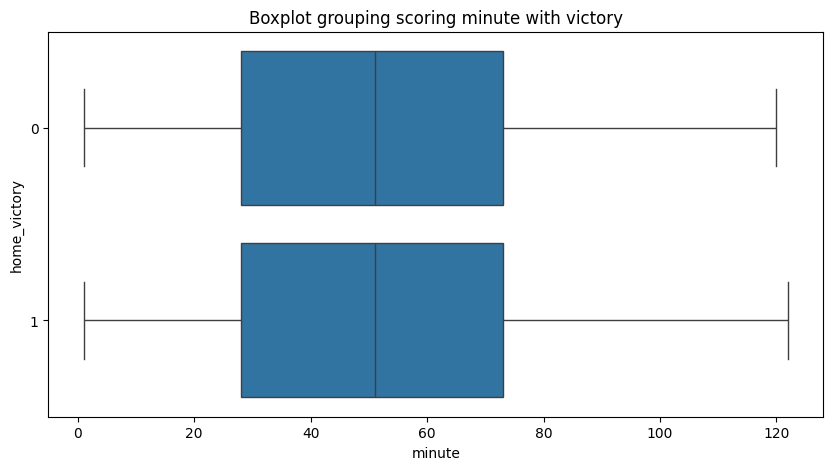

Minute correlation: -0.0041


In [5]:
"""Assess the value of including minute data"""
minute_data = results.loc[results["minute"].notnull()]

fig, ax0 = plt.subplots(1,1, figsize=[10,5])
sbn.boxplot(data=minute_data, x="minute", y="home_victory", orient="h").set(title="Boxplot grouping scoring minute with victory")
plt.show()

print("Minute correlation:", round(np.corrcoef(minute_data["home_victory"], minute_data["minute"])[0,1], 4))

In [6]:
"""Miunte was sparse and offers no insight - remove it"""
results = results.drop(columns=["minute"])
results.head(n=1)

,home_team,away_team,home_score,away_score,tournament,neutral,first_shooter,own_goal,penalty,draw,home_victory,shootout_required
0,Scotland,England,0,0,Friendly,0,0,0,0,1,0,0


In [7]:
"""Check to ensure there are no missing values"""
nulls = pd.DataFrame(results.isnull().sum(), columns=["columns_with_null_values"])
nulls = nulls[nulls["columns_with_null_values"] > 0]
assert len(nulls) == 0
print("no null values in dataset")

no null values in dataset


In [8]:
"""Five-number summary for each column in dataset"""
results.describe()

,home_score,away_score,neutral,first_shooter,own_goal,penalty,draw,home_victory,shootout_required
count,77966.000000,77966.000000,77966.000000,77966.000000,77966.000000,77966.000000,77966.000000,77966.000000,77966.000000
mean,2.232229,1.401162,0.263025,0.003360,0.010530,0.037991,0.175795,0.530385,0.011069
std,2.225011,1.599573,0.440279,0.057872,0.102076,0.191176,0.380648,0.499079,0.104626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,31.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


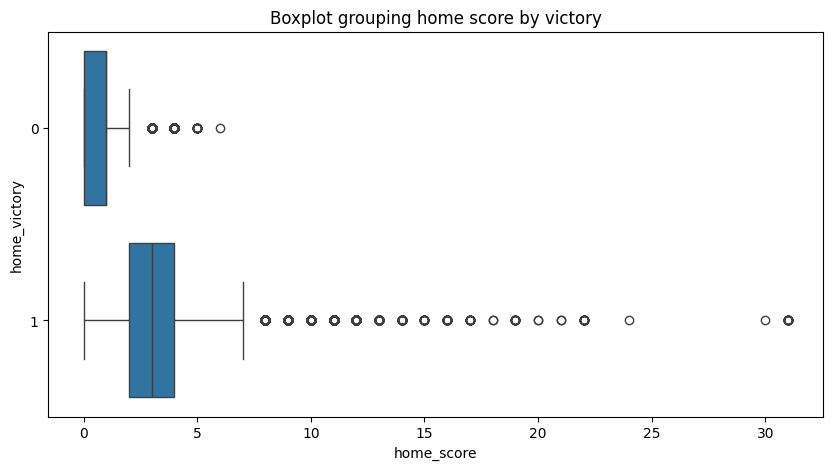

Home score correlation: 0.59


In [9]:
"""Box plot and correlation"""
fig, ax0 = plt.subplots(1,1, figsize=[10,5])
sbn.boxplot(data=results, x="home_score", y="home_victory", orient="h").set(title="Boxplot grouping home score by victory")
plt.show()

print("Home score correlation:", round(np.corrcoef(results["home_victory"], results["home_score"])[0,1], 2))

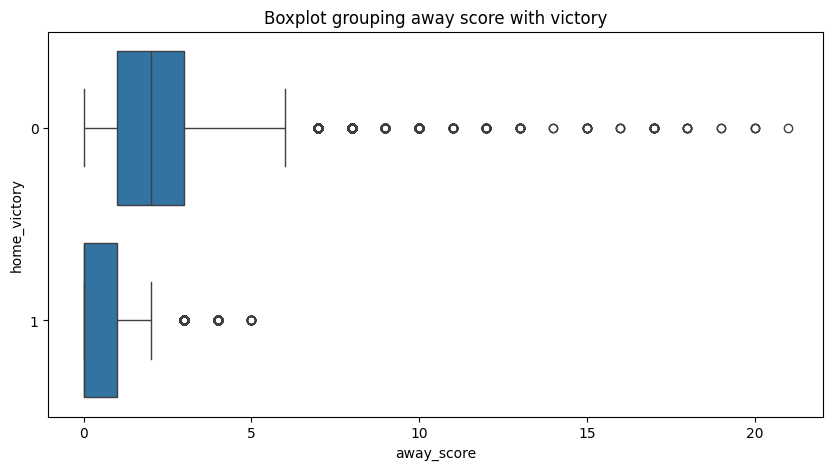

Away score correlation: -0.53


In [10]:
"""Box plot and correlation"""
fig, ax0 = plt.subplots(1,1, figsize=[10,5])
sbn.boxplot(data=results, x="away_score", y="home_victory", orient="h").set(title="Boxplot grouping away score with victory")
plt.show()

print("Away score correlation:", round(np.corrcoef(results["home_victory"], results["away_score"])[0,1], 2))

In [11]:
"""Simple proportional stats for various goals and game types"""
no_penalty, penalty = results.value_counts("penalty")
not_own, own = results.value_counts("own_goal")
not_neutral, neutral = results.value_counts("neutral")

print("percentage of goals that were penalty shots:", round(100 * penalty / (penalty + no_penalty), 2))
print("percentage of goals that were own goals:", round(100 * own / (own + not_own), 2))
print("percentage of games played on neutral turf:", round(100 * neutral / (neutral + not_neutral), 2))

percentage of goals that were penalty shots: 3.8
percentage of goals that were own goals: 1.05
percentage of games played on neutral turf: 26.3


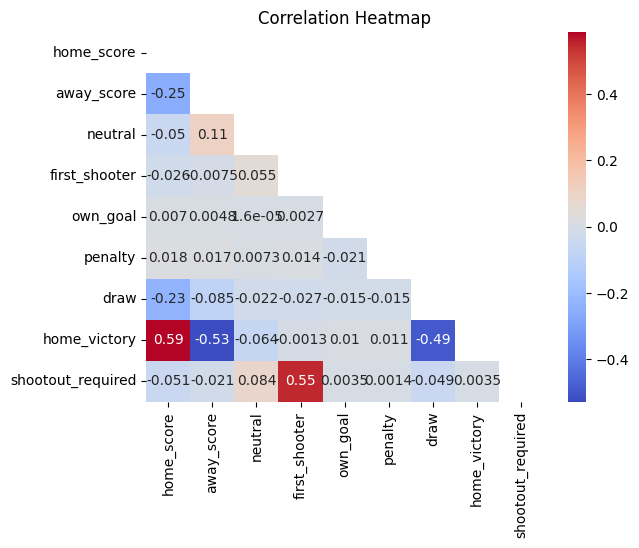

In [12]:
"""Correlation heatmap of non-categorical data"""
correlation_values = results.corr(numeric_only=True)
sbn.heatmap(correlation_values, annot=True, mask=np.triu(correlation_values), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [13]:
"""One hot encoding for categorical data: home_team, away_tem, and tournament"""
dummied_results = pd.get_dummies(results, columns=["home_team"])
dummied_results = pd.get_dummies(dummied_results, columns=["away_team"])
dummied_results = pd.get_dummies(dummied_results, columns=["tournament"])

dummied_results.head(n=1)

,home_score,away_score,neutral,first_shooter,own_goal,penalty,draw,home_victory,shootout_required,home_team_Abkhazia,...,tournament_United Arab Emirates Friendship Tournament,tournament_VFF Cup,tournament_Vietnam Independence Cup,tournament_Viva World Cup,tournament_WAFF Championship,tournament_West African Cup,tournament_Windward Islands Tournament,tournament_World Unity Cup,tournament_Zambian Independence Tournament,tournament_Évence Coppée Trophy
0,0,0,0,0,0,0,1,0,0,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
"""Set an arbitrary significance level and drop all columns that don't meet this level"""
SIG_LEVEL = .05

significant = []
for col in dummied_results.columns:
    if np.abs(np.corrcoef(dummied_results["home_victory"], dummied_results[col])[0,1]) > SIG_LEVEL:
        significant.append(col)

significant_results = dummied_results[significant]
significant_results.head(n=1)

,home_score,away_score,neutral,draw,home_victory,home_team_Andorra,home_team_Argentina,home_team_Brazil,home_team_Liechtenstein,home_team_Luxembourg,...,away_team_Brazil,away_team_Cyprus,away_team_England,away_team_Germany,away_team_Liechtenstein,away_team_Luxembourg,away_team_Malta,away_team_San Marino,away_team_Spain,tournament_Friendly
0,0,0,0,1,0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [15]:
"""Create training data with hold out data to validate against and measure prediction accuracy"""
response_variable = significant_results[["home_victory"]]
explanatory_variables = significant_results.loc[:, significant_results.columns != "home_victory"]

explanatory_variables, validation_explanatory, response_variable, validation_response = train_test_split(explanatory_variables, response_variable, test_size=0.2, random_state=73)

print(len(response_variable), "records for training")
print(len(validation_response), "records for testing")

62372 records for training
15594 records for testing


In [21]:
"""Fit Logistic Regression model to training data"""
model = LogisticRegression()
model.fit(explanatory_variables, response_variable.values.ravel())

coefficients = pd.DataFrame(model.coef_.T, columns=["coefficient"])
variables = pd.DataFrame(explanatory_variables.columns, columns=["variable"])
coefficient_summary = pd.concat([variables["variable"], coefficients["coefficient"]], axis=1)

print("Intercept:", model.intercept_)
print(coefficient_summary)

Intercept: [0.02873408]
                   variable  coefficient
0                home_score     7.050078
1                away_score    -7.015505
2                   neutral    -0.154516
3                      draw    -7.469295
4         home_team_Andorra    -0.030360
5       home_team_Argentina     0.704154
6          home_team_Brazil     0.181895
7   home_team_Liechtenstein    -0.033326
8      home_team_Luxembourg    -0.070167
9           home_team_Malta    -0.081416
10     home_team_San Marino    -0.024894
11          home_team_Spain     0.100353
12         away_team_Brazil    -0.443446
13         away_team_Cyprus     0.003554
14        away_team_England     0.456377
15        away_team_Germany     0.147800
16  away_team_Liechtenstein     0.011456
17     away_team_Luxembourg    -0.000573
18          away_team_Malta     0.007733
19     away_team_San Marino    -0.022722
20          away_team_Spain     0.108488
21      tournament_Friendly     0.290156


In [30]:
"""Make predictions using hold out data"""
predictions = pd.DataFrame(model.predict_proba(validation_explanatory), columns=["lose_prob", "win_prob"])
predictions["prediction"] = model.predict(validation_explanatory)
predictions["correct"] = validation_response.reset_index()["home_victory"]
predictions.head()

,lose_prob,win_prob,prediction,correct
0,1.000000e+00,5.932081e-13,0,0
1,0.000000e+00,1.000000e+00,1,1
2,0.000000e+00,1.000000e+00,1,1
3,4.218867e-07,9.999996e-01,1,1
4,1.000000e+00,7.928769e-10,0,0


In [32]:
"""Calculate error rates and prediction accuracy"""
validation = mean_absolute_error(predictions["prediction"], validation_response)
correct_predictions =  predictions.loc[predictions["prediction"] == predictions["correct"]]

print("Mean Absolute Error:", round(validation, 4))
print(f"Percentage of correct predictions: {100 * len(correct_predictions) / len(predictions):.2f}%")

Mean Absolute Error: 0.0053
Percentage of correct predictions: 99.47%
